# Implementing a Gaussian Process for Regression
In the notebook, we implement the Gaussian process model for regression.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it

from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Automobile Mileage
We will be using a small set of automobile data. In particular, we will attempt to predict the mileage of a car from the following attributes:
- number of cylinders
- displacement
- horsepower
- weight
- acceleration
- model year

The data is broken into training and testing sets. Each row in both $X$ objects contains the above six features for a single car and an additional $1$ in the $7^{th}$ dimension for the bias term. The same row in the corresponding $y$ object contains the MPG for that car.

In [4]:
data_path = os.path.join('data','cars')

X_train = np.genfromtxt(os.path.join(data_path, 'X_train.csv'), delimiter = ',')
y_train = np.genfromtxt(os.path.join(data_path, 'y_train.csv'))

X_test = np.genfromtxt(os.path.join(data_path, 'X_test.csv'), delimiter = ',')
y_test = np.genfromtxt(os.path.join(data_path, 'y_test.csv'))

print('X_train has {} observations and {} features'.format(X_train.shape[0], X_train.shape[1]))
print('y_train has {} labels'.format(len(y_train)))
print('X_test has {} observations and {} features'.format(X_test.shape[0], X_test.shape[1]))
print('y_test has {} labels'.format(len(y_test)))

X_train has 350 observations and 7 features
y_train has 350 labels
X_test has 42 observations and 7 features
y_test has 42 labels


# Gaussian Process
In Bayesian linear regression, for $n$ observations with response vector $y \in \mathbb{R}^n$ and their feature matrix $X$, we define the likelihood and prior:
$$y \sim N(Xw, \sigma^2I)$$ $$w \sim N(0, \lambda^{-1}I)$$

If we integrate out $w$, we can derive the following:

$$p(y|X) = \int p(y|X,w)p(w)dw = N(0, \sigma^2I+\lambda^{-1}XX^T)$$

Because $(XX^T)_{ij} = x_i^Tx_j$, if we replace each $x$ with $\phi(x)$, then $[\phi(X)\phi(X)^T]_{ij} = K(x_i, x_j)$, where $K$ is the kernel corresponding to the feature mapping $\phi$. This allows us to rewrite:

$$p(y|X) = N(0, \sigma^2I+\lambda^{-1}K)$$

The above is called a **Gaussian process** in which we never use $w$ or $\phi(x)$, but just $K$ directly.

Imagine we have $n$ observation pairs $\mathcal{D}_n = \{(x_i, y_i)\}^N_{i=1}$. Then under Bayesian linear regression:

$$y_0|\mathcal{D}_n, x_0 \sim \mathcal{N}(\mu_0, \sigma_0^2)$$

where

$$\mu_0 = (Xx_0)^T(\sigma^2I+XX^T)^{-1}y$$
$$\sigma_0^2 = \sigma^2 + x_0^Tx_0 - (Xx_0)^T(\sigma^2I+XX^T)^{-1}(Xx_0)$$

The above expressions can be kernelized. Let $K(x, \mathcal{D}_n) = [K(x, x_1), ..., K(x,x_n)]$ and $K_n$ be the $n \times n$ kernel matrix, then we can show:

$$y(x)|\mathcal{D}_n \sim \mathcal{N}(\mu(x), \Sigma(x))$$

where

$$\mu(x) = K(x, \mathcal{D}_n)(\sigma^2I+K_n)^{-1}y$$
$$\Sigma(x) = \sigma^2 + K(x, x) - K(x, \mathcal{D}_n)(\sigma^2I + K_n)^{-1}K(x, \mathcal{D}_n)^T$$

Below, we define $K(x, x')$ to be the RBF kernel:

$$K(x, x') = e^{-\frac{1}{b}\left\|x - x'\right\|_2^2}$$

Intuitively, if applying a quadratic expansion of the data $X$ allows a linear model to learn a quadratic function for $y$, then using an RBF kernel is akin to applying an infinite-degree feature expansion on $X$.

The model below implements a Gaussian process using the RBF kernel and makes predictions for $y$ using the mean of the kernelized predictive distribution ($\mu(x)$ defined above). All functions have been vectorized for fast training and prediction times.

In [5]:
class GaussianProcess():
    def __init__(self, variance = 1, bandwidth = 1):
        self.variance = variance
        self.bandwidth = bandwidth
        self.K = None
        self.X_train = None
        self.X_train_l2s = None
        self.y_train = None
        
    def fit(self, X, y):
        # let n be the number of rows of X
        # create an n x n matrix of pairwise dot products of all rows of X
        dots = np.dot(X, X.T)
        
        # create an n-dimensional column vector of squared norms of each row
        l2s = np.linalg.norm(X, axis = 1).reshape(-1, 1) ** 2
        
        # K is now an n x n matrix of squared pairwise distances
        K = l2s - 2 * dots + l2s.T
        
        # convert K to Gaussian kernel matrix
        self.K = np.exp((-1 / self.bandwidth) * K)
        
        self.X_train = X.copy()
        self.X_train_l2s = l2s
        self.y_train = y.copy()
        
        return self
    
    def predict(self, X):
        
        # let n be the number of rows of X_train and m that of X
        # create an m x n matrix of pairwise dot products between rows X
        # ...and X_train
        dots = np.dot(X, self.X_train.T)
        
        # create an m-dimensional column vector of squared norms of each row
        # ...of X
        X_l2s = np.linalg.norm(X, axis = 1).reshape(-1, 1) ** 2
        
        # n-dimensional column vector of squared norms of each row of X_train
        X_train_l2s = self.X_train_l2s
        
        # K_prime is now an m x n matrix of squared pairwise distances
        # ...between rows of X and X_train
        K_prime = X_l2s - 2 * dots + X_train_l2s.T
        
        # convert K_prime to Gaussian kernel matrix
        K_prime = np.exp((-1 / self.bandwidth) * K_prime)
        
        # calculate predictions using mean of predictive distributions
        n = self.K.shape[0]
        inv = np.linalg.inv(self.variance * np.eye(n) + self.K)
        preds = K_prime.dot(inv).dot(self.y_train)
        
        return preds.squeeze()
    
def RMSE(y, y_pred):
    return np.sqrt(((y - y_pred)**2).mean())

The Gaussian process we have implemented accepts two hyperparameters: $\sigma^2$ (variance) and $b$ (bandwidth). $\sigma^2$ represents the amount of noise we expect to observe in $y$ and, for training data, controls how much a prediction $\hat{y}_i$ can deviate from the ground truth $y_i$. The bandwidth $b$ controls how quickly $K(x, x')$ tends towards $0$ as the Euclidean distance between $x$ and $x'$ increases.

For $b \in \{5,7,9,11,13,15\}$ and $\sigma^2 \in \{.1,.2,.3,.4,.5,.6,.7,.8,.9,1\}$--so 60 total pairs $(b, \sigma^2)$--, we calculate the RMSE on the 42 test points of the mileage data set.

Setting the hyperparameters to $b = 11$ and $\sigma^2 = 0.1$ yields the best test RMSE of $1.89051$. This is a significant improvement over the $2.19$ RMSE achieved on the same dataset using [regularized ridge regression on polynomial features](https://github.com/zhao1701/machine-learning-implementations/blob/master/ridge-regression.ipynb).

Text(0.5,1.15,'Test RMSE vs. Hyperparameters')

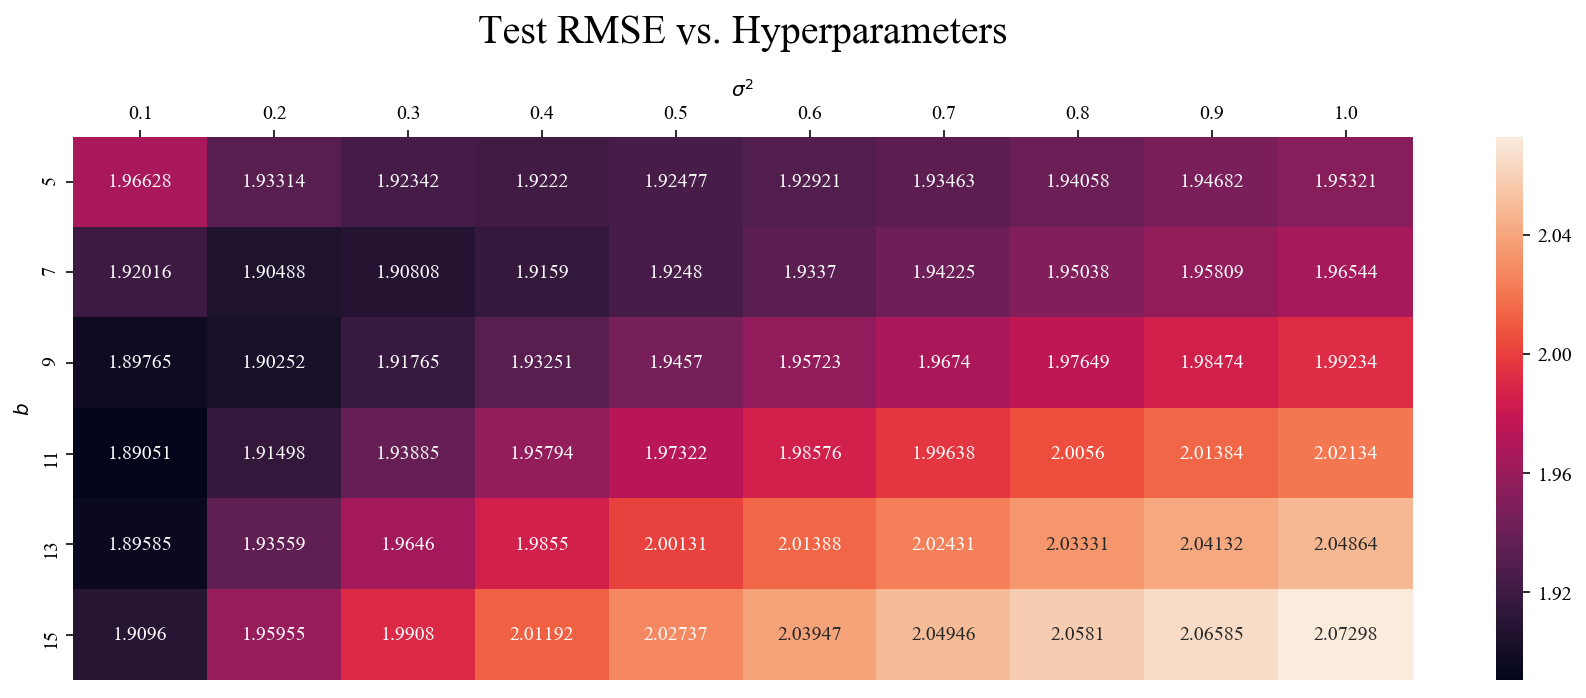

In [6]:
bandwidths = np.arange(5, 17, 2)
variances = np.arange(.1, 1.1, .1)

params = list(it.product(bandwidths, variances))
rmse_list = list()
for param in params:
    gp = GaussianProcess(bandwidth=param[0], variance=param[1])
    gp.fit(X_train, y_train)
    y_test_pred = gp.predict(X_test)
    rmse = RMSE(y_test, y_test_pred)
    rmse_list.append(rmse)
    
rmse_array = np.array(rmse_list)
rmse_array = rmse_array.reshape(len(bandwidths), len(variances))
rmse_df = pd.DataFrame(rmse_array, index=bandwidths, columns=variances)

plt.figure(figsize = (15,5))
ax = sns.heatmap(rmse_df, annot=True, fmt='g')
ax.set(xlabel = '$\sigma^2$', ylabel = '$b$')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_title('Test RMSE vs. Hyperparameters', y = 1.15, fontsize = 20)

To better understand what the Gaussian process is doing through visualization, we re-run the algorithm by using *only* the 4th dimension of $x_i$ (car weight). Using $b = 5$ and $\sigma^2=2$, we plot $x[4]$ versus $y$ for each point as well as a solid line for the predictive mean of the Gaussian process at each point *in the training set*.

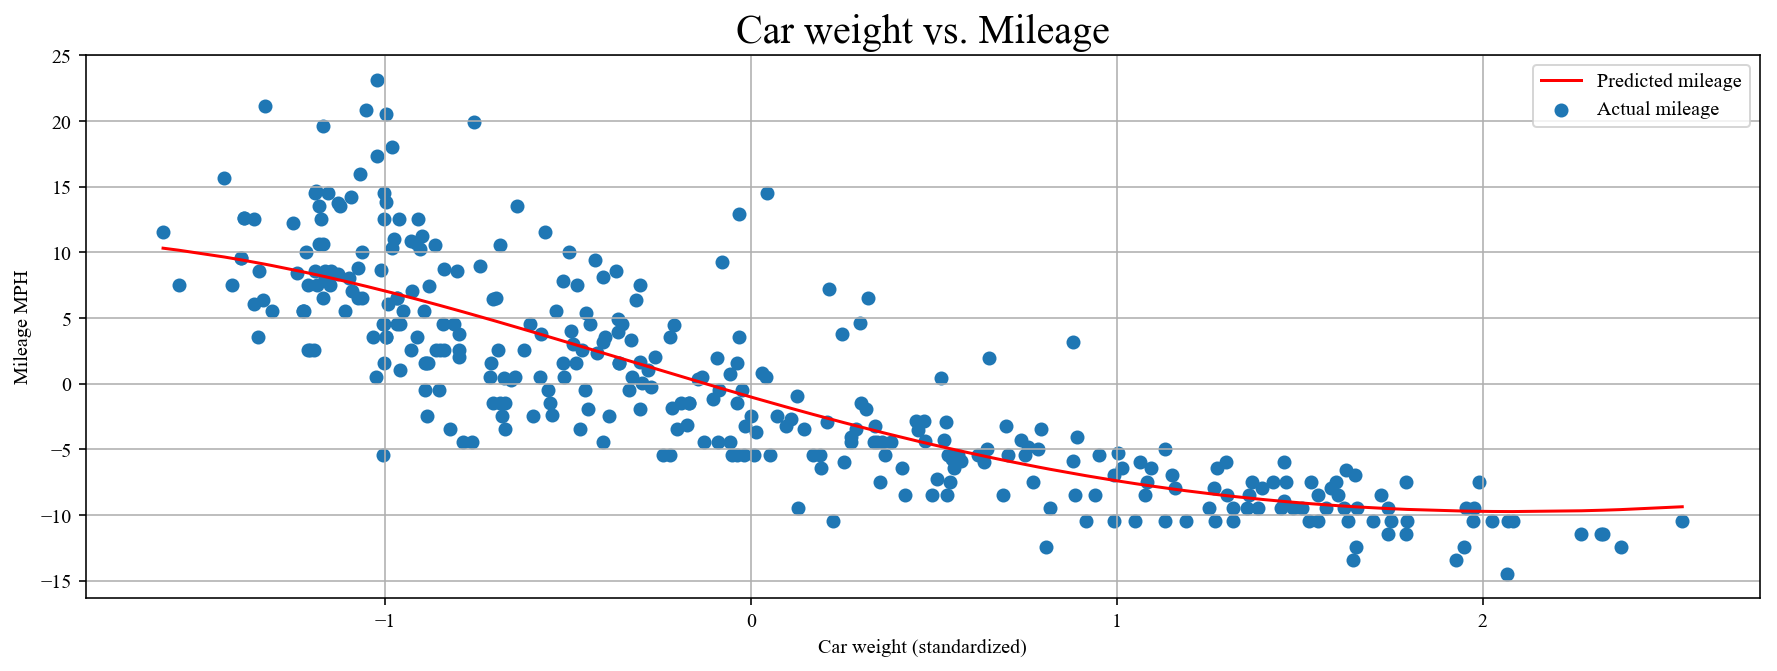

In [7]:
x = X_train[:,3].reshape(-1, 1)
gp = GaussianProcess(bandwidth=5, variance=2)
gp.fit(x, y_train)
y_train_pred = gp.predict(x)

plt.figure(figsize=(15,5))
plt.scatter(x, y_train, label = 'Actual mileage')
plt.plot(sorted(x.squeeze()), y_train_pred[np.argsort(x.squeeze())],
            color='red', label = 'Predicted mileage')
plt.grid(True)
plt.title('Car weight vs. Mileage', fontsize = 20)
plt.xlabel('Car weight (standardized)')
plt.ylabel('Mileage MPH')
plt.legend()